# Neurokit2 PPG Simulations

As part to understand the PPG data deeply, we use the simulation from the Neuro Kit. 

### PPG Simulation

```yaml
ppg_simulate()

ppg_simulate(duration=120, sampling_rate=1000, heart_rate=70, frequency_modulation=0.2, ibi_randomness=0.1, drift=0, motion_amplitude=0.1, powerline_amplitude=0.01, burst_number=0, burst_amplitude=1, random_state=None, random_state_distort='spawn', show=False)

return:
-----
ppg (array) – A vector containing the PPG.

Simulate a photoplethysmogram (PPG) signal


parameters:
-----
- duration (int) :
    Desired recording length in seconds. The default is 120.

-  sampling_rate (int):
    The desired sampling rate (in Hz, i.e., samples/second). The default is 1000.

- heart_rate (int):
    Desired simulated heart rate (in beats per minute). The default is 70. Note that for the ECGSYN method, random fluctuations are to be expected to mimic a real heart rate. These fluctuations can cause some slight discrepancies between the requested heart rate and the empirical heart rate, especially for shorter signals.

- frequency_modulation (float):
    Float between 0 and 1. Determines how pronounced respiratory sinus arrythmia (RSA) is (0 corresponds to absence of RSA). The default is 0.3.

- ibi_randomness (float):
    Float between 0 and 1. Determines how much random noise there is in the duration of each PPG wave (0 corresponds to absence of variation). The default is 0.1.

- drift (float):
    Float between 0 and 1. Determines how pronounced the baseline drift (.05 Hz) is (0 corresponds to absence of baseline drift). The default is 1.

- motion_amplitude (float):
    Float between 0 and 1. Determines how pronounced the motion artifact (0.5 Hz) is (0 corresponds to absence of motion artifact). The default is 0.1.

- powerline_amplitude (float):
    Float between 0 and 1. Determines how pronounced the powerline artifact (50 Hz) is (0 corresponds to absence of powerline artifact). Note that powerline_amplitude > 0 is only possible if sampling_rate is >= 500. The default is 0.1.

- burst_amplitude (float):
    Float between 0 and 1. Determines how pronounced high frequency burst artifacts are (0 corresponds to absence of bursts). The default is 1.

- burst_number (int):
    Determines how many high frequency burst artifacts occur. The default is 0.

- show (bool):
    If True, returns a plot of the landmarks and interpolated PPG. Useful for debugging.

- random_state (None, int, numpy.random.RandomState or numpy.random.Generator):
    Seed for the random number generator. See for misc.check_random_state for further information.

-  random_state_distort ({‘legacy’, ‘spawn’}, None, int, numpy.random.RandomState or numpy.random.Generator):
    Random state to be used to distort the signal. If "legacy", use the same random state used to generate the signal (discouraged as it creates dependent random streams). If "spawn", spawn independent children random number generators from the random_state argument. If any of the other types, generate independent children random number generators from the random_state_distort provided (this allows generating multiple version of the same signal distorted by different random noise realizations).

```

<hr style="border:20px solid red; border-radius:5px">

### Find Peaks
```yaml
find_peaks()

find_peaks(x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)

returns:
------
- peaksndarray : Indices of peaks in x that satisfy all given conditions.
- propertiesdict : A dictionary containing properties of the returned peaks which were calculated as intermediate results during evaluation/

parameters:
--------
- x [sequence] : 
    A signal with peaks.

- height [number or ndarray or sequence], optional:
    Required height of peaks. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required height.

- threshold [number or ndarray or sequence], optional:
    Required threshold of peaks, the vertical distance to its neighboring samples. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

- distance [number, optional]: 
    Required minimal horizontal distance (>= 1) in samples between neighbouring peaks. Smaller peaks are removed first until the condition is fulfilled for all remaining peaks.

- prominence [number or ndarray or sequence, optional]:
    Required prominence of peaks. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required prominence.

- width [number or ndarray or sequence], optional:
    Required width of peaks in samples. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required width.

- wlenint, optional:
    Used for calculation of the peaks prominences, thus it is only used if one of the arguments prominence or width is given. See argument wlen in peak_prominences for a full description of its effects.

- rel_height [float], optional:
    Used for calculation of the peaks width, thus it is only used if width is given. See argument rel_height in peak_widths for a full description of its effects.

- plateau_size [number or ndarray or sequence], optional:
    Required size of the flat top of peaks in samples. Either a number, None, an array matching x or a 2-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied as the maximal required plateau size.

```

<hr style="border:20px solid blue; border-radius:5px">

### Notes:

Based on the signal, it seems we have similar pattern enough, I guess with little bit of normalization, we can have this pattern.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
import neurokit2 as nk

# Simulate a PPG signal with `ibi_randomness` to add noise
fs = 64  # Sampling frequency (Hz)
duration = 120  # Duration of signal (seconds)
ppg_signal = nk.ppg_simulate(duration=duration, 
                             sampling_rate=fs, 
                             heart_rate=70, 
                             frequency_modulation=0.5, 
                             ibi_randomness=1, 
                             drift=0.5, 
                             motion_amplitude=0.5, 
                             powerline_amplitude=0.5, 
                             burst_number=1, 
                             burst_amplitude=1, 
                             random_state=42, 
                             random_state_distort='spawn', 
                             show=False)

# Bandpass filter design
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Apply bandpass filter (0.5–4 Hz for typical heart rates)
filtered_ppg = bandpass_filter(ppg_signal, lowcut=0.5, highcut=4, fs=fs, order=4)

# Peak detection
min_distance = int(fs * 0.6)  # Minimum distance between peaks (corresponds to ~100 BPM)
peaks, properties = find_peaks(filtered_ppg, distance=min_distance, prominence=0.2)

# Plot the results
time = np.linspace(0, duration, len(ppg_signal))

plt.figure(figsize=(12, 6))
plt.plot(time, ppg_signal, label="Raw PPG Signal", alpha=0.6)
plt.plot(time, filtered_ppg, label="Filtered PPG Signal", alpha=0.8)
plt.scatter(time[peaks], filtered_ppg[peaks], color="red", label="Detected Heartbeats")
plt.title("PPG Signal with Detected Heartbeats")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

# Heart rate estimation
ibi = np.diff(peaks) / fs  # Inter-beat intervals (seconds)
heart_rate = 60 / ibi  # Heart rate in beats per minute (BPM)

# Display heart rate statistics
mean_hr = np.mean(heart_rate)
std_hr = np.std(heart_rate)
print(f"Mean Heart Rate: {mean_hr:.2f} BPM")
print(f"Heart Rate Standard Deviation: {std_hr:.2f} BPM")


<hr style="border:20px solid green; border-radius:5px">

### Notes
As per side by side comparison, this would be the perfect PPG signal, it seems just adjusting the amplitude to be the equal with each other peak, it seems any peak is the Heart beat.

In [ ]:
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Simulate a realistic PPG signal
sampling_rate = 64  # Lower sampling rate, similar to oximeters
duration = 120  # 1-minute duration
print(f"Simulating PPG signal with sampling rate={sampling_rate} Hz and duration={duration} seconds")
ppg_signal = nk.ppg_simulate(duration=duration, sampling_rate=sampling_rate, ibi_randomness=0.7)
print(f"PPG signal generated with {len(ppg_signal)} samples")

# Detect peaks in the raw PPG signal (candidate heartbeats)
print("Detecting peaks in the raw PPG signal...")
peaks, _ = find_peaks(ppg_signal, distance=sampling_rate * 0.6)  # Assuming heart rate > 60 bpm
print(f"Number of peaks detected in raw signal: {len(peaks)}")

# Apply a moving average for smoothing
window_size = int(sampling_rate * 0.5)  # 0.5-second window
print(f"Applying moving average with window size={window_size} samples")
smoothed_signal = np.convolve(ppg_signal, np.ones(window_size) / window_size, mode='same')
print("Moving average applied")

# Detect peaks in the smoothed signal
print("Detecting peaks in the smoothed PPG signal...")
smoothed_peaks, _ = find_peaks(smoothed_signal, distance=sampling_rate * 0.6)
print(f"Number of peaks detected in smoothed signal: {len(smoothed_peaks)}")

# Plotting the signals and detected peaks
print("Plotting the results...")
plt.figure(figsize=(15, 6))

# Plot raw PPG signal
plt.subplot(2, 1, 1)
plt.plot(ppg_signal, label="Raw PPG Signal", color="blue")
plt.plot(peaks, ppg_signal[peaks], "x", label="Detected Peaks (Raw)", color="red")
plt.title("Raw PPG Signal and Detected Peaks")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()

# Plot smoothed PPG signal
plt.subplot(2, 1, 2)
plt.plot(smoothed_signal, label="Smoothed PPG Signal", color="green")
plt.plot(smoothed_peaks, smoothed_signal[smoothed_peaks], "o", label="Detected Peaks (Smoothed)", color="orange")
plt.title("Smoothed PPG Signal and Detected Peaks")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

# Print peak counts for comparison
print(f"Number of peaks detected in raw signal: {len(peaks)}")
print(f"Number of peaks detected in smoothed signal: {len(smoothed_peaks)}")


<hr style="border:20px solid magenta; border-radius:5px">

### Notes:
it seems after preprocessing such as filtering, it's fine to normalize it:
- if want to be around 0 - 1 (Standarization) amp value 
- or with Normalization since either to set the mean and std to be 0 so it like with the original data.

But let's use the Standarization (Min-Max Scaling)

Also notes onthe moving average, it seems by using mean, it kinda work to set the trend of the signal, we can use it as the advantage.

On the other side. since the signal is well aligned on the amplitude max-peak, we can use the regular finds_peaks and set with the distace so it normally mimick the human beat interval (`around fs * 0.6 `). So we just care for the peaks, and that peak is the heart beat. (Hypothesis).



Simulating PPG signal with sampling rate=64 Hz and duration=120 seconds
Skipping random IBI modulation, since the offset_weight 0.99 leads to physiologically implausible wave durations of 6.430729143125702 milliseconds.
PPG signal generated with 7680 samples
Detecting peaks in the raw PPG signal...
Number of peaks detected in raw signal: 140
Prominence of detected peaks in raw signal: [1.51453974 1.56265426 1.67022631 1.23349669 1.59896787 0.69651007
 1.50677584 2.41882845 1.49544951 1.36842064 1.35223247 1.32374323
 1.64697632 1.54186655 1.4723873  1.35904681 1.34073219 1.46637383
 1.56401513 1.31847204 2.18417169 1.39444999 1.5914475  1.57307978
 1.47035335 1.49038703 1.58017731 1.32285407 1.21434041 2.15879999
 1.3866978  1.57297347 1.47464467 1.10536269 1.7188916  1.37945703
 2.2179628  1.39765543 1.46591816 1.27686648 1.34436283 1.5791236
 1.38617169 2.36081578 1.29383339 1.1145247  1.11560463 1.25170359
 1.55056951 1.42966116 2.50125476 1.31793556 1.50576446 1.36985997
 1.5722607

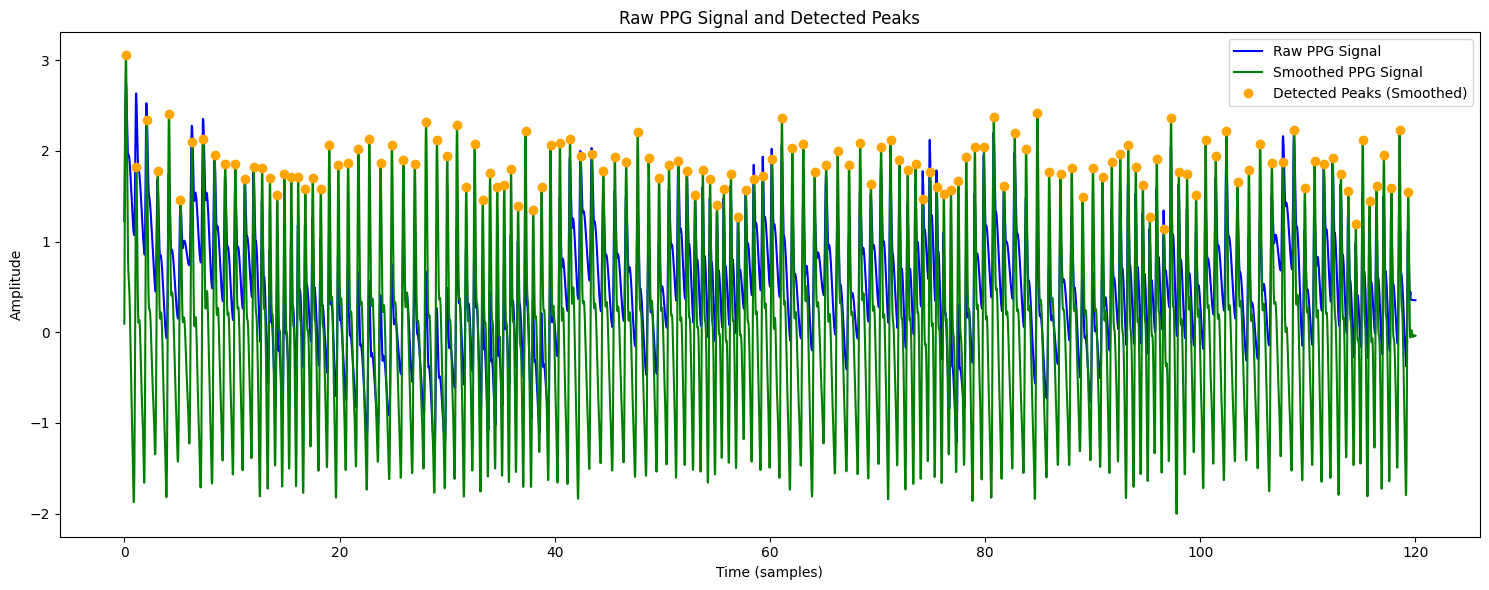

Number of peaks detected in raw signal: 140
Number of peaks detected in smoothed signal: 140


In [2]:
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt

# Simulate a realistic PPG signal
sampling_rate = 64  # Higher sampling rate to mimic real-world PPG devices
duration = 120  # 2-minute duration
print(f"Simulating PPG signal with sampling rate={sampling_rate} Hz and duration={duration} seconds")
ppg_signal = nk.ppg_simulate(duration=duration, 
                             sampling_rate=sampling_rate, 
                             heart_rate=70, 
                             frequency_modulation=0.5, 
                             ibi_randomness=1, 
                             drift=0.5, 
                             motion_amplitude=0.5, 
                             powerline_amplitude=0.5, 
                             burst_number=1, 
                             burst_amplitude=1, 
                             random_state=42, 
                             random_state_distort='spawn', 
                             show=False)
print(f"PPG signal generated with {len(ppg_signal)} samples")

# Detect peaks in the raw PPG signal (candidate heartbeats)
print("Detecting peaks in the raw PPG signal...")
peaks, properties = find_peaks(ppg_signal, distance=sampling_rate * 0.6, prominence=0.1)  # Assuming heart rate > 60 bpm, with prominence
print(f"Number of peaks detected in raw signal: {len(peaks)}")
print(f"Prominence of detected peaks in raw signal: {properties['prominences']}")

# Plot the results
duration = np.linspace(0, duration, len(ppg_signal))

# Apply a moving average for smoothing
window_size = int(sampling_rate * 0.5)  # 0.5-second window
print(f"Applying moving average with window size={window_size} samples")
smoothed_signal = np.convolve(ppg_signal, np.ones(window_size) / window_size, mode='same')
print("Moving average applied")

# Bandpass filter design
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Apply bandpass filter (0.5–4 Hz for typical heart rates)
smoothed_signal = bandpass_filter(ppg_signal, lowcut=0.5, highcut=4, fs=sampling_rate, order=4)

## Normalize the Smoothed Signal 
smoothed_signal = (smoothed_signal - np.mean(smoothed_signal)) / np.std(smoothed_signal)

## Normalize using Min Max Scaling
# smoothed_signal = (smoothed_signal - np.min(smoothed_signal)) / (np.max(smoothed_signal) - np.min(smoothed_signal))

# Detect peaks in the smoothed signal
print("Detecting peaks in the smoothed PPG signal...")
smoothed_peaks, smoothed_properties = find_peaks(smoothed_signal, distance=sampling_rate * 0.6, prominence=0.5) # Adjusted prominence for smoothed signal
print(f"Number of peaks detected in smoothed signal: {len(smoothed_peaks)}")
print(f"Prominence of detected peaks in smoothed signal: {smoothed_properties['prominences']}")

# Plotting the signals and detected peaks
print("Plotting the results...")
plt.figure(figsize=(15, 6))

# Plot raw PPG signal
# plt.subplot(2, 1, 1)
plt.plot(duration, ppg_signal, label="Raw PPG Signal", color="blue")
# plt.plot(duration[peaks], ppg_signal[peaks], "x", label="Detected Peaks (Raw)", color="red")
plt.plot(duration, smoothed_signal, label="Smoothed PPG Signal", color="green")
plt.plot(duration[smoothed_peaks], smoothed_signal[smoothed_peaks], "o", label="Detected Peaks (Smoothed)", color="orange")
plt.title("Raw PPG Signal and Detected Peaks")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()

# Plot smoothed PPG signal
# plt.subplot(2, 1, 2)
# plt.plot(duration, smoothed_signal, label="Smoothed PPG Signal", color="green")
# plt.plot(duration[smoothed_peaks], smoothed_signal[smoothed_peaks], "o", label="Detected Peaks (Smoothed)", color="orange")
# plt.title("Smoothed PPG Signal and Detected Peaks")
# plt.xlabel("Time (samples)")
# plt.ylabel("Amplitude")
# plt.legend()

plt.tight_layout()
plt.show()

# Print peak counts for comparison
print(f"Number of peaks detected in raw signal: {len(peaks)}")
print(f"Number of peaks detected in smoothed signal: {len(smoothed_peaks)}")
